# googlemaps-groundoverlay-example

This notebook shows a two-step solution to plotting heatmaps on Google Maps. We first transform the raw data into a smoothed heatmap layer stored into a transparent image file, and then overlay this image onto Google Maps using gmplot’s ground_overlay method.

See full blog post [here](https://medium.com/paololucchino/heatmaps-that-you-can-fully-control-using-google-maps-and-gmplot-22257aa16782)

### Let's get some data

We use the location of [planning permission in London](https://data.london.gov.uk/dataset/planning-permissions-on-the-london-development-database--ldd-). so we’ll go with the location of planning permission applications in London. This dataset references locations using UK Postcodes. These were easily convered using online tools such as [this one](https://gridreferencefinder.com/postcodeBatchConverter/).

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/planning-applications-clean.csv')
df['Longitude'] = pd.to_numeric(df['Longitude'])
df['Latitude'] = pd.to_numeric(df['Latitude'])
df = df[df['Longitude']>-1]
df.shape

(65475, 3)

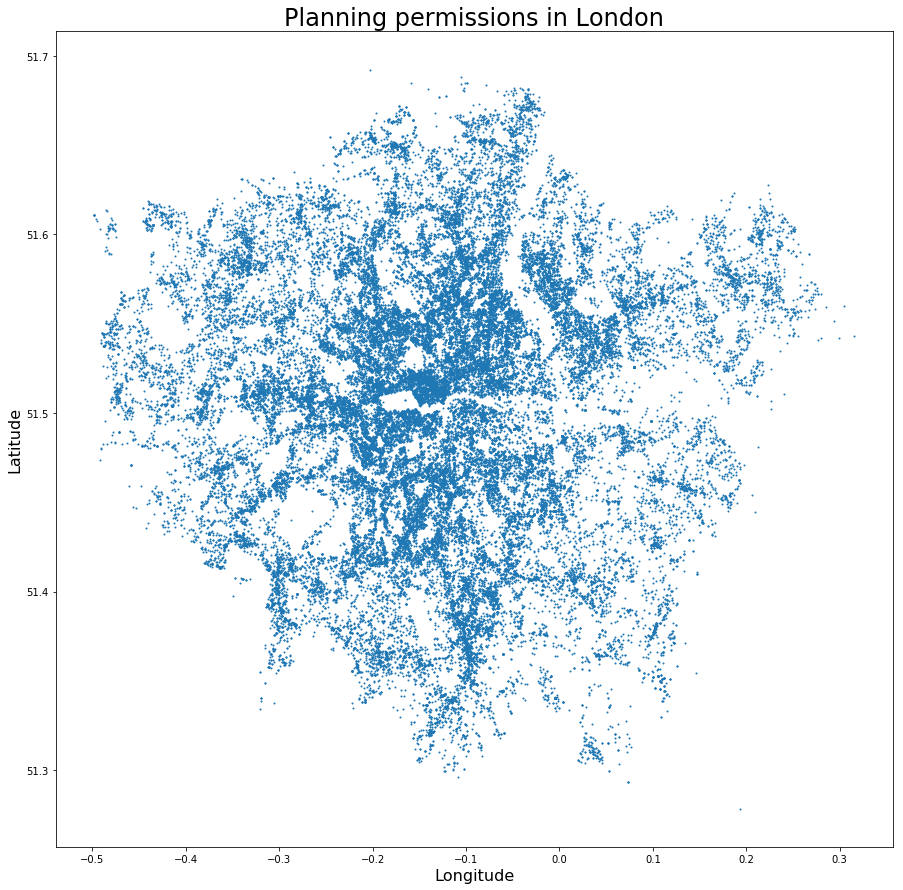

In [2]:
# Let's plot the data to sense-check it
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))
plt.scatter(df['Longitude'], df['Latitude'], s=1)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Planning permissions in London', fontsize=24)
plt.savefig('output/scatterplot.png', format='png', dpi=250, pad_inches=0)
plt.show()

In [3]:
# Take a random sample of the data to speed-up the next steps. It's just an example after all...
df = df.sample(15000)
lats = df['Latitude']
lons = df['Longitude']

### Constucting the heatmap layer

In [ ]:
# Identify the data bounds
xmin = lons.min()
xmax = lons.max()
ymin = lats.min()
ymax = lats.max()

# Construct grid locations
grid_points = 150
X, Y = np.mgrid[xmin:xmax:complex(grid_points,1), ymin:ymax:complex(grid_points,1)]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([lons, lats])

# Run a kernel density estimation
from scipy import stats
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions), X.shape)

# Mask grid locations will little data
Z[Z<1] = np.nan

### Drawing the image

In [ ]:
# Plot figure. Various parameters to ensure image only plots the data
# See https://github.com/matplotlib/matplotlib/issues/7940/
fig = plt.figure(frameon=True)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_aspect('equal')
ax.set_axis_off()
ax.tick_params(which='both', direction='in')
fig.add_axes(ax)

# Plot the data
ax.imshow(np.rot90(Z),cmap='coolwarm', alpha=0.6, extent=[xmin, xmax, ymin, ymax])

## Save figure
# To ensure image has no padding around it.
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('heatmap.png', format='png', dpi=300, transparent=True, bbox_inches=extent, pad_inches=0)

# Let's look at it
plt.show()

### Setting up Google Maps API

Some admin first though, I'm afraid. Google Maps API now expects all requests to provide an api key. It's quick and free, and if you have some familiarity with the Google Cloud Platform it'll be easy. See [here for step by step instructions](https://developers.google.com/maps/documentation/javascript/get-api-key).
You could hardcode your API KEY in your code if you wish, but to keep credentials separate from what's on version control, I created a separate `api_key.py`:

In [ ]:
api_key = 'MY_API_KEY'

If you take this approach, remember to add it to your `.gitignore`! 

Once that is set up, you can import your key:

In [ ]:
from api_key import api_key

### Adjusting the image bounds

Here’s the fiddly thing. Our data is over 150 x 150 grid points, but our image is over the corresponding 150 x 150 grid squares. The north-west corner of our data will be the location of the most northwest grid point, but the most north-west corner of our image will be the location of the north-west corner of the grid square containing the most north-west grid point. (Tongue-twister isn’t it? Can you say it 10 times really fast?) Bottom line is that, compared to our data bounds, we need to stretch our image bounds slightly, as in these formulae:

In [ ]:
# Overlay on map
lon_midpt = np.mean([xmin, xmax])
lat_midpt = np.mean([ymin, ymax])

img_bounds = {}
img_bounds['west'] = (xmin - lon_midpt) * (grid_points / (grid_points - 1)) + lon_midpt
img_bounds['east'] = (xmax - lon_midpt) * (grid_points / (grid_points - 1)) + lon_midpt
img_bounds['north'] = (ymax - lat_midpt) * (grid_points / (grid_points - 1)) + lat_midpt
img_bounds['south'] = (ymin - lat_midpt) * (grid_points / (grid_points - 1)) + lat_midpt

### Plotting using gmplot

We are almost there.. but hang on. We need to make sure we have the latest version of gmplot, as the ground_overlay feature will only be available from the next release. No biggie; just pip install the version on github via the terminal.

```$ pip install git+git://github.com/vgm64/gmplot@d53cd1cf4767f4d147834eb915b0daccdd0bcd27#egg=gmplot```

And finally:

In [ ]:
import gmplot
lat_center = np.median(lats)
lon_center = np.median(lons)
gmap = gmplot.GoogleMapPlotter(lat_center, lon_center, zoom=11, apikey=api_key)

gmap.ground_overlay('heatmap.png', img_bounds)
gmap.scatter(lats, lons, '#3B0B39', size=15, marker=False)

# Draw map and save locally
gmap.draw('map.html')

Just open the file in a browser and enjoy the result!